In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



In [9]:
# Ruta al archivo CSV
file_path = "../data/csv/fomc_sentiment_full.csv"

# Leer CSV 
df = pd.read_csv(file_path, quotechar='"')


In [10]:

# Mostrar las primeras filas
df.head()


,Date,Release Date,Type,Text,Sentiment_Score,Sentiment_Label
0,2025-05-07,2025-05-28,Minute,Minutes of the Federal Open Market Committee\n...,0.9999,positive
1,2025-05-07,2025-05-07,Statement,Although swings in net exports have affected t...,0.6249,positive
2,2025-03-19,2025-03-19,Statement,Recent indicators suggest that economic activi...,0.9306,positive
3,2025-03-19,2025-04-09,Minute,Minutes of the Federal Open Market Committee\n...,0.9998,positive
4,2025-01-29,2025-01-29,Statement,Recent indicators suggest that economic activi...,0.7717,positive


In [4]:
import yfinance as yf
import pandas as pd

# -----------------------------
# CONFIGURACIÓN
# -----------------------------
tickers = ['SAN.MC', 'BBVA.MC']
period = 'max'
interval = '1d'

# -----------------------------
# DESCARGAR DATOS
# -----------------------------
# auto_adjust=False para que Close sea el precio real
data = yf.download(tickers, period=period, interval=interval, auto_adjust=False)

# -----------------------------
# FUNCIONES AUXILIARES
# -----------------------------
def add_features(df):
    # Rango diario
    df['range'] = df['high'] - df['low']
    
    # Retornos diarios
    df['return'] = df['close'].pct_change()
    
    # SMA 5 y 10 días
    df['sma_5'] = df['close'].rolling(window=5).mean()
    df['sma_10'] = df['close'].rolling(window=10).mean()
    
    # Volumen relativo (comparado con media de 10 días)
    df['vol_rel'] = df['volume'] / df['volume'].rolling(window=10).mean()
    
    # Solo eliminar filas donde Close sea NaN (no por rolling)
    df = df[df['close'].notna()]
    
    return df

# -----------------------------
# PROCESAR Y GUARDAR POR TICKER
# -----------------------------
for ticker in tickers:
    # Seleccionar columnas de cada ticker usando xs
    df = data.xs(ticker, level=1, axis=1).copy()
    
    # Renombrar columnas a minúsculas
    df.columns = [col.lower() for col in df.columns]
    
    # Añadir features adicionales
    df = add_features(df)
    
    # Guardar CSV
    df.to_csv(f'{ticker.replace(".MC","")}_features.csv')
    print(f'CSV generado: {ticker.replace(".MC","")}_features.csv')


[*********************100%***********************]  2 of 2 completed


CSV generado: SAN_features.csv
CSV generado: BBVA_features.csv


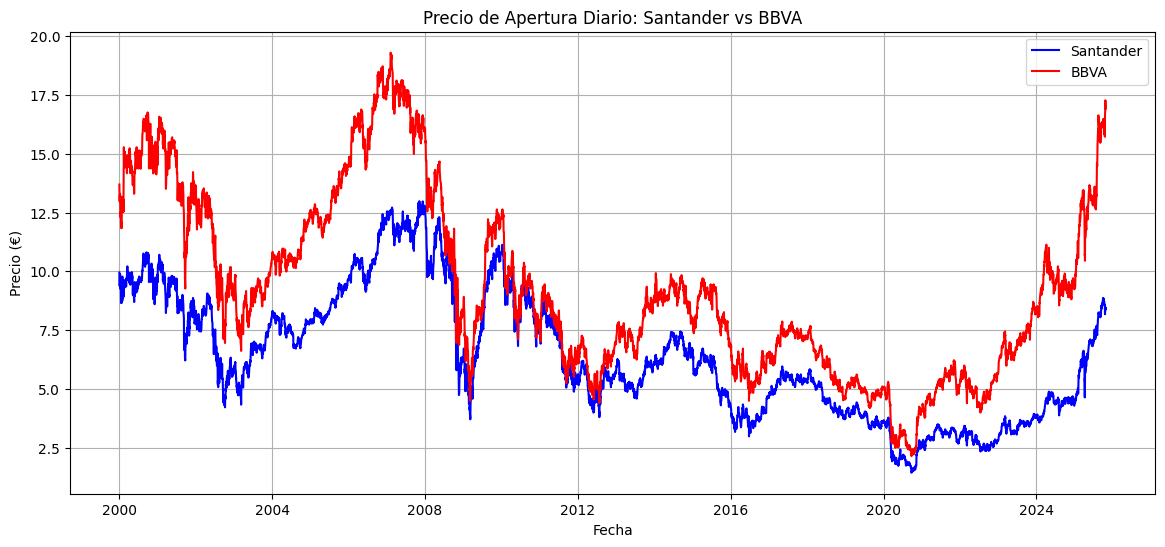

In [11]:
# Cargar CSV
df_san = pd.read_csv('..\data\csv\SAN_features.csv', index_col=0, parse_dates=True)
df_bbva = pd.read_csv('..\data\csv\BBVA_features.csv', index_col=0, parse_dates=True)

# Graficar precio de apertura
plt.figure(figsize=(14,6))
plt.plot(df_san.index, df_san['open'], label='Santander', color='blue')
plt.plot(df_bbva.index, df_bbva['open'], label='BBVA', color='red')

plt.title('Precio de Apertura Diario: Santander vs BBVA')
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')
plt.legend()
plt.grid(True)
plt.show()


In [55]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from datetime import datetime

# ====================================================
# --- 1. Cargar dataset de sentimiento ---
# ====================================================
df_sent = pd.read_csv('../data/csv/fomc_sentiment_extended_recent.csv')

# Normalizar nombres (sin espacios ni mayúsculas)
df_sent.columns = [c.strip().lower() for c in df_sent.columns]

# Detectar la columna de fecha
fecha_cols = [c for c in df_sent.columns if "date" in c]
if not fecha_cols:
    raise ValueError("❌ No se encontró ninguna columna de fecha en el CSV de sentimiento.")
fecha_col = fecha_cols[0]

# Convertir a datetime
df_sent[fecha_col] = pd.to_datetime(df_sent[fecha_col], errors='coerce')
df_sent = df_sent.rename(columns={fecha_col: 'release_date'})

print("✅ Columna de fecha detectada:", fecha_col)
print(df_sent.head())

# ====================================================
# --- 2. Cargar datasets de precios ---
# ====================================================
df_san = pd.read_csv('../data/csv/SAN_features.csv', parse_dates=True, index_col=0)
df_bbva = pd.read_csv('../data/csv/BBVA_features.csv', parse_dates=True, index_col=0)

df_san.index = pd.to_datetime(df_san.index)
df_bbva.index = pd.to_datetime(df_bbva.index)

# ====================================================
# --- 3. Fusionar sentimiento (por fecha más cercana anterior) ---
# ====================================================

def procesar_sentimiento(df_sent, df_price):
    df_sent = df_sent.copy()
    df_price = df_price.copy()

    # Asegurar detección de columnas correctas
    col_label = [c for c in df_sent.columns if "label" in c][0]          # 'sentiment_label'
    col_score = [c for c in df_sent.columns if "score" in c][0]          # 'sentiment_score'
    col_event = [c for c in df_sent.columns if "sentiment_value" in c]   # 'sentiment_value' (ahora detecta mayúsculas)
    col_event = col_event[0] if col_event else None

    # Ordenar por fecha
    df_sent = df_sent.sort_values("release_date").reset_index(drop=True)
    df_price = df_price.sort_index()

    # Inicializar columnas
    df_price["sentiment_score"] = np.nan
    df_price["Sentiment_Numeric"] = np.nan

    j = 0
    for i, date in enumerate(df_price.index):
        # Mover puntero al release_date más reciente <= fecha
        while j + 1 < len(df_sent) and df_sent.loc[j + 1, "release_date"] <= date:
            j += 1

        row = df_sent.loc[j]
        label = str(row.get(col_label, "")).strip().lower()
        score = float(row.get(col_score, 0.0))
        event_val = float(row.get(col_event, np.nan)) if col_event else np.nan

        # --- Fórmula original que tú y yo definimos ---
        if not np.isnan(event_val):        # evento artificial
            value = event_val
        elif label == "positive":
            value = score
        elif label == "negative":
            value = -score
        elif label == "neutral":
            value = (score - 0.5) * 0.3    # leve sesgo neutral
        else:
            value = 0.0

        df_price.loc[date, "sentiment_score"] = score
        df_price.loc[date, "Sentiment_Numeric"] = value

    # Rellenar huecos iniciales
    df_price["sentiment_score"] = df_price["sentiment_score"].ffill().fillna(0)
    df_price["Sentiment_Numeric"] = df_price["Sentiment_Numeric"].ffill().fillna(0)

    return df_price.replace([np.inf, -np.inf], np.nan).fillna(0)


# Aplicar función
df_san = procesar_sentimiento(df_sent, df_san)
df_bbva = procesar_sentimiento(df_sent, df_bbva)

print("✅ Fusión + asignación de sentimiento completada.")
print(df_san[["sentiment_score", "Sentiment_Numeric"]].head(15))

# ====================================================
# --- 4. Escalado conjunto ---
# ====================================================
scaler_san = MinMaxScaler()
features_san_scaled = scaler_san.fit_transform(df_san.values)

scaler_bbva = MinMaxScaler()
features_bbva_scaled = scaler_bbva.fit_transform(df_bbva.values)

print("\n✅ Escalado completado correctamente.")
print("SAN shape:", features_san_scaled.shape)
print("BBVA shape:", features_bbva_scaled.shape)

print(f"\n👉 Rango Sentiment_Numeric SAN: {df_san['Sentiment_Numeric'].min()} → {df_san['Sentiment_Numeric'].max()}")
print(f"👉 Rango Sentiment_Numeric BBVA: {df_bbva['Sentiment_Numeric'].min()} → {df_bbva['Sentiment_Numeric'].max()}")


✅ Columna de fecha detectada: release_date
  release_date sentiment_label  sentiment_score                fuente  \
0   2000-02-02        negative           0.4313             FOMC real   
1   2000-03-10        negative           0.7000  Histórico artificial   
2   2000-03-21         neutral           0.3599             FOMC real   
3   2000-03-23         neutral           0.3668             FOMC real   
4   2000-05-16         neutral           0.3501             FOMC real   

   sentiment_value                      evento  
0              NaN                         NaN  
1             -0.7  Pinchazo burbuja punto-com  
2              NaN                         NaN  
3              NaN                         NaN  
4              NaN                         NaN  
✅ Fusión + asignación de sentimiento completada.
            sentiment_score  Sentiment_Numeric
Date                                          
2000-01-03           0.4313            -0.4313
2000-01-04           0.4313       

In [56]:
# ====================================================
# --- 5. Añadir medias móviles ---
# ====================================================

for df in [df_san, df_bbva]:
    df["MA10"] = df["close"].rolling(window=10).mean()
    df["MA30"] = df["close"].rolling(window=30).mean()
    df["MA60"] = df["close"].rolling(window=60).mean()

# Eliminamos posibles NaN generados al inicio de las medias
df_san = df_san.dropna()
df_bbva = df_bbva.dropna()

print("✅ Medias móviles añadidas correctamente.")
print(df_san[["close", "MA10", "MA30", "MA60"]].head(15))


✅ Medias móviles añadidas correctamente.
                close       MA10      MA30      MA60
Date                                                
2000-03-24   9.979226   9.980957  9.621198  9.369481
2000-03-27   9.884021  10.001729  9.650336  9.370058
2000-03-28  10.057121  10.030291  9.680340  9.377415
2000-03-29   9.961916  10.041542  9.691880  9.387079
2000-03-30   9.832091  10.023367  9.699381  9.394580
2000-03-31   9.719576   9.968840  9.711210  9.393282
2000-04-03   9.736886   9.916910  9.718134  9.393715
2000-04-04   9.840746   9.888349  9.732847  9.401360
2000-04-05   9.676301   9.853729  9.735155  9.407707
2000-04-06   9.399341   9.808722  9.736886  9.410736
2000-04-07   9.589751   9.769775  9.742945  9.412900
2000-04-10   9.762851   9.757658  9.756504  9.422132
2000-04-11   9.615716   9.713517  9.762563  9.436702
2000-04-12   9.702266   9.687552  9.772083  9.452713
2000-04-13   9.935951   9.697938  9.784489  9.469591


In [57]:
# ====================================================
# --- 6. Crear dataset con ventanas temporales ---
# ====================================================

def create_windowed_dataset(features, target_col_index=-3, window_size=5):
    """
    Crea un dataset con ventanas temporales de tamaño 'window_size'.
    - features: array de características escaladas (n_días x n_features)
    - target_col_index: índice de la columna que se quiere predecir (por defecto la penúltima, 'Close')
    - window_size: nº de días en la ventana
    """
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i+window_size])
        y.append(features[i+window_size][target_col_index])
    return np.array(X), np.array(y).reshape(-1, 1)

window_size = 5

X_san, y_san = create_windowed_dataset(features_san_scaled, window_size=window_size)
X_bbva, y_bbva = create_windowed_dataset(features_bbva_scaled, window_size=window_size)

print(f"SAN -> X: {X_san.shape}, y: {y_san.shape}")
print(f"BBVA -> X: {X_bbva.shape}, y: {y_bbva.shape}")


SAN -> X: (6625, 5, 13), y: (6625, 1)
BBVA -> X: (6625, 5, 13), y: (6625, 1)


In [58]:
# ====================================================
# --- 7. Tensores y DataLoaders ---
# ====================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# Convertir arrays numpy → tensores de PyTorch
X_san_t = torch.tensor(X_san, dtype=torch.float32).to(device)
y_san_t = torch.tensor(y_san, dtype=torch.float32).to(device)
X_bbva_t = torch.tensor(X_bbva, dtype=torch.float32).to(device)
y_bbva_t = torch.tensor(y_bbva, dtype=torch.float32).to(device)

# Cargadores de datos (batch training)
batch_size = 64
san_loader = DataLoader(TensorDataset(X_san_t, y_san_t), batch_size=batch_size, shuffle=True)
bbva_loader = DataLoader(TensorDataset(X_bbva_t, y_bbva_t), batch_size=batch_size, shuffle=True)

print("✅ Tensores y DataLoaders listos.")


Usando dispositivo: cuda
✅ Tensores y DataLoaders listos.


In [59]:
# ====================================================
# --- 8. Definir el modelo LSTM ---
# ====================================================

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # salida del último timestep

# Crear modelo para cada banco
input_dim = X_san_t.shape[2]  # número de columnas (features)

model_san = LSTMModel(input_dim).to(device)
model_bbva = LSTMModel(input_dim).to(device)

print("✅ Modelos LSTM inicializados correctamente.")


✅ Modelos LSTM inicializados correctamente.


In [60]:
# ====================================================
# --- 9. Entrenamiento ---
# ====================================================

criterion = nn.MSELoss()  # Error cuadrático medio
optimizer_san = optim.Adam(model_san.parameters(), lr=0.001)
optimizer_bbva = optim.Adam(model_bbva.parameters(), lr=0.001)

num_epochs = 600
print("\n🚀 Entrenando modelos...\n")

for epoch in range(1, num_epochs+1):
    model_san.train()
    model_bbva.train()

    epoch_loss_san, epoch_loss_bbva = 0, 0

    # --- Santander ---
    for xb, yb in san_loader:
        optimizer_san.zero_grad()
        output = model_san(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer_san.step()
        epoch_loss_san += loss.item() * xb.size(0)
    epoch_loss_san /= len(san_loader.dataset)
    
    # --- BBVA ---
    for xb, yb in bbva_loader:
        optimizer_bbva.zero_grad()
        output = model_bbva(xb)
        loss = criterion(output, yb)
        loss.backward()
        
        optimizer_bbva.step()
        epoch_loss_bbva += loss.item() * xb.size(0)
    epoch_loss_bbva /= len(bbva_loader.dataset)

    # --- Progreso ---
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs} | "
              f"Loss SAN: {epoch_loss_san:.6f} | "
              f"Loss BBVA: {epoch_loss_bbva:.6f}")

print("\n✅ Entrenamiento completado.")



🚀 Entrenando modelos...

Epoch 10/600 | Loss SAN: 0.009464 | Loss BBVA: 0.007605
Epoch 20/600 | Loss SAN: 0.009391 | Loss BBVA: 0.007515
Epoch 30/600 | Loss SAN: 0.009330 | Loss BBVA: 0.007492
Epoch 40/600 | Loss SAN: 0.009281 | Loss BBVA: 0.007431
Epoch 50/600 | Loss SAN: 0.009209 | Loss BBVA: 0.007416
Epoch 60/600 | Loss SAN: 0.009205 | Loss BBVA: 0.007409
Epoch 70/600 | Loss SAN: 0.009106 | Loss BBVA: 0.007347
Epoch 80/600 | Loss SAN: 0.008996 | Loss BBVA: 0.007303
Epoch 90/600 | Loss SAN: 0.008969 | Loss BBVA: 0.007182
Epoch 100/600 | Loss SAN: 0.008891 | Loss BBVA: 0.007121
Epoch 110/600 | Loss SAN: 0.008769 | Loss BBVA: 0.006948
Epoch 120/600 | Loss SAN: 0.008725 | Loss BBVA: 0.006855
Epoch 130/600 | Loss SAN: 0.008587 | Loss BBVA: 0.006811
Epoch 140/600 | Loss SAN: 0.008499 | Loss BBVA: 0.006706
Epoch 150/600 | Loss SAN: 0.008408 | Loss BBVA: 0.006537
Epoch 160/600 | Loss SAN: 0.008235 | Loss BBVA: 0.006418
Epoch 170/600 | Loss SAN: 0.008082 | Loss BBVA: 0.006227
Epoch 180/600 

Rango real BBVA -> Mín: 1.65 € | Máx: 17.30 €


C:\Users\josit\AppData\Local\Temp\ipykernel_2560\3631383043.py:96: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\josit\CUARTO CURSO\APRENDIZAJE AUTOMATICO\Caso02_Prediccion_BBVA_SANTANDER\env11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


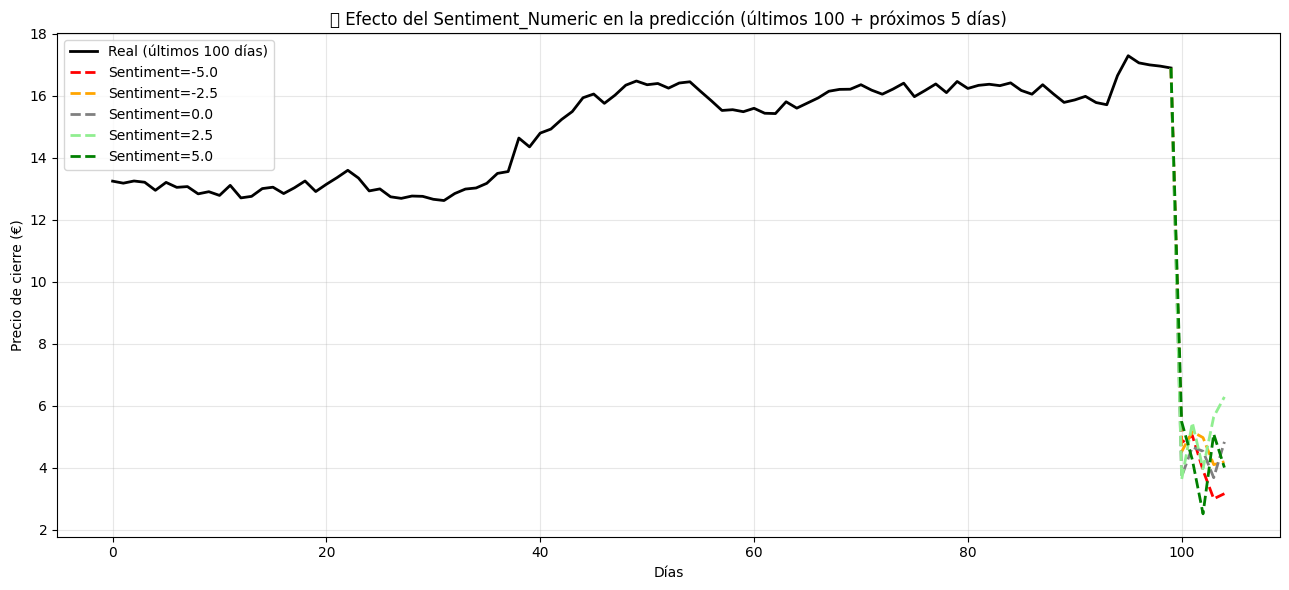

📈 Predicciones simuladas según sentimiento (en €):
   Sentiment_Value                  Predicciones_5_Días
0             -5.0    [4.82, 5.045, 3.925, 3.005, 3.17]
1             -2.5    [4.524, 5.169, 4.978, 4.106, 4.2]
2              0.0  [3.723, 4.671, 4.539, 3.686, 4.841]
3              2.5   [3.627, 5.459, 3.975, 5.65, 6.291]
4              5.0   [5.49, 4.262, 2.521, 5.094, 4.013]


In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tseries.offsets import BDay

# ====================================================
# --- 1️⃣ Guardar los valores originales de cierre ---
# ====================================================
close_col_bbva = [c for c in df_bbva.columns if "close" in c.lower()][0]
close_min_bbva, close_max_bbva = df_bbva[close_col_bbva].min(), df_bbva[close_col_bbva].max()

print(f"Rango real BBVA -> Mín: {close_min_bbva:.2f} € | Máx: {close_max_bbva:.2f} €")

# ====================================================
# --- 2️⃣ Funciones auxiliares ---
# ====================================================
def predict_future(model, features_scaled, window_size, close_idx, sentiment_idx, sentiment_override=None, horizon=5):
    """
    Predice 'horizon' días hacia adelante de forma autoregresiva.
    Si 'sentiment_override' se da, sustituye ese valor de sentimiento en cada paso.
    """
    model.eval()
    with torch.no_grad():
        last_window = torch.tensor(features_scaled[-window_size:], dtype=torch.float32, device=device).unsqueeze(0)
        preds = []
        for _ in range(horizon):
            if sentiment_override is not None:
                last_window[:, -1, sentiment_idx] = sentiment_override

            out = model(last_window)
            pred_close_scaled = out.squeeze().item()
            preds.append(pred_close_scaled)

            # Nueva fila = última con cierre predicho
            new_row = last_window[:, -1, :].clone()
            new_row[:, close_idx] = pred_close_scaled
            if sentiment_override is not None:
                new_row[:, sentiment_idx] = sentiment_override

            last_window = torch.cat([last_window[:, 1:, :], new_row.unsqueeze(1)], dim=1)
    return np.array(preds)

def inverse_close_from_scaled(pred_scaled_1d, close_min, close_max):
    """
    Desescala manualmente la columna 'Close' según sus límites reales.
    """
    return pred_scaled_1d * (close_max - close_min) + close_min

# ====================================================
# --- 3️⃣ Preparar índices e info del modelo ---
# ====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cols = df_bbva.columns
close_idx_bbva = [i for i, c in enumerate(cols) if "close" in c.lower()][0]
sentiment_idx_bbva = [i for i, c in enumerate(cols) if "sentiment_numeric" in c.lower()][0]
nfeat_bbva = features_bbva_scaled.shape[1]
window_size = 5

# ====================================================
# --- 4️⃣ Predicciones con distintos sentimientos ---
# ====================================================
sentiment_values = [-5.0, -2.5, 0.0, 2.5, 5.0]
predicciones = {}

for val in sentiment_values:
    preds_scaled = predict_future(
        model_bbva, features_bbva_scaled, window_size,
        close_idx=close_idx_bbva, sentiment_idx=sentiment_idx_bbva,
        sentiment_override=val, horizon=5
    )
    preds_real = inverse_close_from_scaled(preds_scaled, close_min_bbva, close_max_bbva)
    predicciones[val] = preds_real

# ====================================================
# --- 5️⃣ Graficar resultados ---
# ====================================================
real_close = df_bbva.iloc[-100:, close_idx_bbva].to_numpy()
last_date = pd.to_datetime(df_bbva.index[-1])
future_dates = pd.bdate_range(start=last_date + BDay(1), periods=5)

plt.figure(figsize=(13, 6))
plt.plot(range(100), real_close, label="Real (últimos 100 días)", color="black", linewidth=2)

colors = ["red", "orange", "gray", "lightgreen", "green"]
for val, col in zip(sentiment_values, colors):
    preds = predicciones[val]
    plt.plot(range(99, 105), np.concatenate([[real_close[-1]], preds]),
             "--", label=f"Sentiment={val}", color=col, linewidth=2)

plt.title("📊 Efecto del Sentiment_Numeric en la predicción (últimos 100 + próximos 5 días)")
plt.xlabel("Días")
plt.ylabel("Precio de cierre (€)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ====================================================
# --- 6️⃣ Mostrar tabla de predicciones ---
# ====================================================
df_pred_sent = pd.DataFrame({
    "Sentiment_Value": sentiment_values,
    "Predicciones_5_Días": [np.round(predicciones[v], 3).tolist() for v in sentiment_values]
})

print("📈 Predicciones simuladas según sentimiento (en €):")
print(df_pred_sent)


C:\Users\josit\AppData\Local\Temp\ipykernel_2560\2801229142.py:68: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\josit\CUARTO CURSO\APRENDIZAJE AUTOMATICO\Caso02_Prediccion_BBVA_SANTANDER\env11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


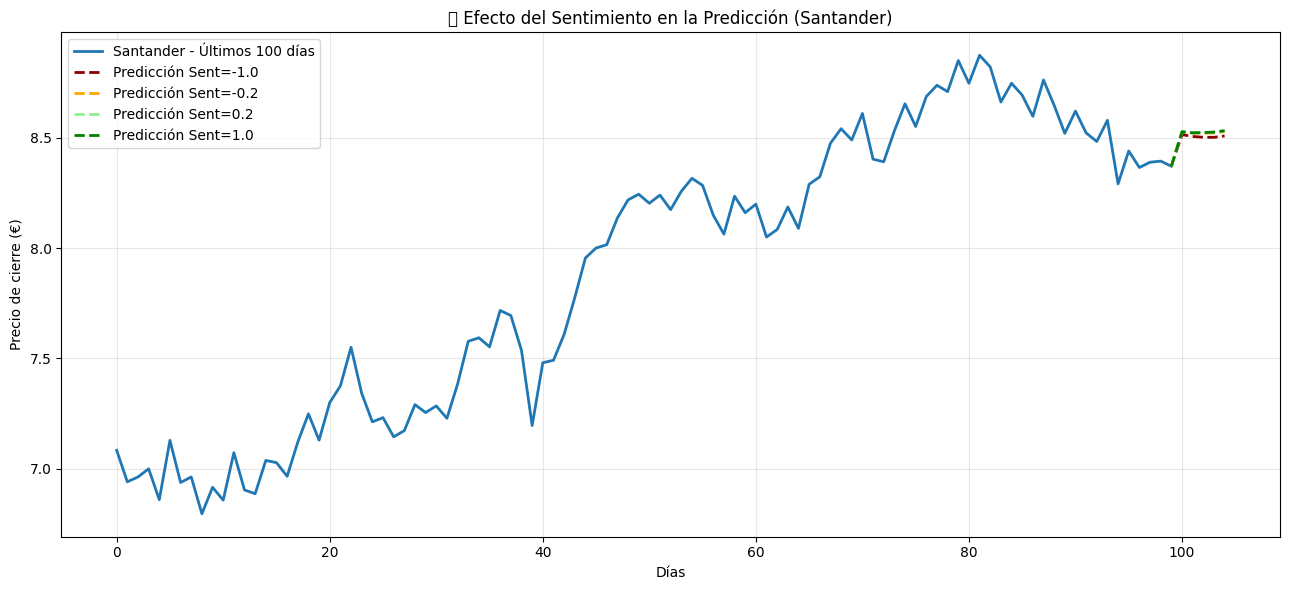

📈 Predicciones simuladas según sentimiento:
   Sentiment_Value                  Predicciones_5_Días
0             -1.0  [8.514, 8.506, 8.502, 8.502, 8.508]
1             -0.2  [8.528, 8.522, 8.521, 8.522, 8.528]
2              0.2  [8.529, 8.524, 8.524, 8.526, 8.533]
3              1.0  [8.527, 8.522, 8.523, 8.525, 8.532]


In [20]:
# ============================================================
# --- BLOQUE 12: Simulación con distintos umbrales de sentimiento ---
# ============================================================

def predict_with_custom_sentiment(model, features_scaled, window_size, close_idx, sentiment_idx, sentiment_value, days_ahead=5):
    """Predice los próximos días reemplazando el sentimiento por un valor fijo."""
    model.eval()
    preds = []
    with torch.no_grad():
        last_window = torch.tensor(features_scaled[-window_size:], dtype=torch.float32).unsqueeze(0).to(device)
        
        # Reemplazamos el sentimiento en toda la ventana
        last_window[:, :, sentiment_idx] = sentiment_value
        
        for _ in range(days_ahead):
            out = model(last_window)
            pred_scaled = out.squeeze().item()
            preds.append(pred_scaled)
            
            # Crear nueva fila actualizada
            new_row = last_window[:, -1, :].clone()
            new_row[:, close_idx] = pred_scaled
            new_row[:, sentiment_idx] = sentiment_value  # mantener constante el sentimiento
            last_window = torch.cat([last_window[:, 1:, :], new_row.unsqueeze(1)], dim=1)
    return np.array(preds)

# --- Identificamos índices ---
close_idx_san = find_close_index(df_san.columns)
sentiment_idx_san = [i for i, c in enumerate(df_san.columns) if "sentiment" in c.lower()][0]

n_features_san = df_san.shape[1]

# --- Simulaciones con distintos valores de sentimiento ---
sentiment_values = [-1.0, -0.2, 0.2, 1.0]
preds_san_dict = {}

for val in sentiment_values:
    preds_scaled = predict_with_custom_sentiment(model_san, features_san_scaled, window_size, close_idx_san, sentiment_idx_san, val)
    preds_san_dict[val] = inverse_close_from_scaled(preds_scaled, scaler_san, n_features_san, close_idx_san)

# --- Datos reales ---
real_san = df_san.iloc[-100:, close_idx_san].values

# --- GRAFICAR ---
plt.figure(figsize=(13, 6))
plt.plot(range(100), real_san, label="Santander - Últimos 100 días", color="tab:blue", linewidth=2)

colors = {
    -1.0: "darkred",
    -0.2: "orange",
    0.2: "lightgreen",
    1.0: "green"
}

for val in sentiment_values:
    plt.plot(range(99, 105),
             np.concatenate([[real_san[-1]], preds_san_dict[val]]),
             "--",
             color=colors[val],
             linewidth=2,
             label=f"Predicción Sent={val}")

plt.title("📊 Efecto del Sentimiento en la Predicción (Santander)")
plt.xlabel("Días")
plt.ylabel("Precio de cierre (€)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- Mostrar los valores numéricos ---
df_pred_sent = pd.DataFrame({
    "Sentiment_Value": sentiment_values,
    "Predicciones_5_Días": [np.round(preds_san_dict[v], 3).tolist() for v in sentiment_values]
})

print("📈 Predicciones simuladas según sentimiento:")
print(df_pred_sent)
